In [1]:
!pip install bertopic
!pip install hf_xet

   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 726.2/726.2 kB 7.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 1.8/216.1 MB 11.2 MB/s eta 0:00:20
    --------------------------------------- 4.2/216.1 MB 10.5 MB/s eta 0:00:21
   - -------------------------------------- 6.6/216.1 MB 10.9 MB/s eta 0:00:20
   - -------------------------------------- 8.1/216.1 MB 9.9 MB/s eta 0:00:22
   - -------------------------------------- 10.7/216.1 MB 10.3 MB/s eta 0:00:20
   -- ------------------------------------- 12.6/216.1 MB 10.1 MB/s eta 0:00:21
   -- ------------------------------------- 14.7/216.1 MB 10.2 MB/s eta 0:00:20
   --- ------------------------------------ 17.6/216.1 MB 10.5 MB/s eta 0:00:19
   --- ------------------------------------ 20.2/216.1 MB 10.8 MB/s eta 0:00:19
   ---- ----------------------------------- 22.8/216.1 MB 11.0 

In [2]:
import pandas as pd
from bertopic import BERTopic

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from langdetect import detect
from googletrans import Translator

# Initialize translation
translator = Translator()

def translate_to_english(text):
    try:
        # Detect language
        lang = detect(text)
        # If it's not English, translate it
        if lang != 'en':
            text = translator.translate(text, src=lang, dest='en').text
    except:
        pass  # If language detection or translation fails, keep the original text
    return text
    

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
# Retain some important stop words
negations = {'not', 'no', 'nor'}
stop_words = stop_words - negations
# Add some stop words
custom_stopwords = {'yeah', 'okay', 'like', 'afternoon'}
stop_words = stop_words.union(custom_stopwords)


# Map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def clean_text(text):
    if isinstance(text, str):
        # Translate to English if needed
        text = translate_to_english(text)

        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'(https|http)(\S+)', '', text)

        # Remove emojis
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"
                                   u"\U0001F300-\U0001F5FF"
                                   u"\U0001F680-\U0001F6FF"
                                   u"\U0001F1E0-\U0001F1FF"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        # Remove usernames
        text = re.sub(r'@(\w+)', '', text)

        # Remove punctuation and non-ASCII characters
        text = re.sub(r'[^\w\s]|[\u0080-\uffff]', '', text)

        # Remove hashtags symbol
        text = re.sub(r'#', '', text)

        # Remove retweet indicators
        text = re.sub(r'\brt\b', '', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]

        # POS tagging
        pos_tags = pos_tag(tokens)

        # Lemmatize using POS tags
        lemmatized_tokens = [
            lemmatizer.lemmatize(token, get_wordnet_pos(pos))
            for token, pos in pos_tags
        ]

        # Join tokens back to text
        text = ' '.join(lemmatized_tokens)

        # Remove leading/trailing and multiple spaces
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)

    return text

In [5]:
df = pd.read_csv("cleaned_taobao_reviews.csv")

df['cleaned'] = df['cleaned_review'].apply(lambda x: clean_text(str(x)))

df[['cleaned_review', 'cleaned']].head()

# Choose sentiment as positive data
# positive_data = df.loc[df['Sentiment'] == 'Positive', 'cleansed data'].tolist()
# all_data = df['cleansed data'].tolist()
all_data = df['cleaned'].tolist()


In [14]:
# Instantiate the BERTopic model
model = BERTopic(nr_topics=20)
topics, probabilities = model.fit_transform(all_data)

model.get_document_info(all_data)

# Topic-1 represents text that has not been assigned to any topic. This usually happens in one of two situations:
#   1.The semantics of the text are so different from those of other texts that they cannot be clustered into any existing topic.
#   2.The length of the text is too short to provide enough semantic information for clustering.

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,ive use app month option good however main iss...,0,0_english_language_chinese_change,"[english, language, chinese, change, version, ...","[change language app english, cant change lang...",english - language - chinese - change - versio...,0.612811,False
1,language barrier unfortunately language option...,0,0_english_language_chinese_change,"[english, language, chinese, change, version, ...","[change language app english, cant change lang...",english - language - chinese - change - versio...,0.889048,False
2,keep sign repeatedly claim security risk accou...,-1,-1_app_account_cant_use,"[app, account, cant, use, get, english, log, t...","[good app english language dont know buy good,...",app - account - cant - use - get - english - l...,0.000000,False
3,pretty satisfy cheap thing though ask sign ove...,1,1_account_log_login_cant,"[account, log, login, cant, number, try, even,...","[cant even login account, cant log account, ca...",account - log - login - cant - number - try - ...,1.000000,False
4,buy two hundred product since last year friend...,2,2_item_refund_pay_seller,"[item, refund, pay, seller, ship, service, fee...",[unsafe app make payment store owner scam mone...,item - refund - pay - seller - ship - service ...,0.996463,False
...,...,...,...,...,...,...,...,...
4995,cant even login account,1,1_account_log_login_cant,"[account, log, login, cant, number, try, even,...","[cant even login account, cant log account, ca...",account - log - login - cant - number - try - ...,0.768768,True
4996,change language please,0,0_english_language_chinese_change,"[english, language, chinese, change, version, ...","[change language app english, cant change lang...",english - language - chinese - change - versio...,0.069949,False
4997,good app,5,5_app_force_download_website,"[app, force, download, website, install, good,...","[force use install use website, force download...",app - force - download - website - install - g...,0.300921,False
4998,good ai,-1,-1_app_account_cant_use,"[app, account, cant, use, get, english, log, t...","[good app english language dont know buy good,...",app - account - cant - use - get - english - l...,0.000000,False


In [15]:
model.get_topic_freq()
# -1 is noise, not clustered into any topic

,Topic,Count
1,-1,1545
0,0,1384
2,1,428
3,2,400
6,3,211
8,4,209
11,5,187
7,6,129
15,7,80
4,8,71


In [16]:
model.get_topic(1)

[('account', 0.07633831333979131),
 ('log', 0.0688440003557141),
 ('login', 0.0667080343131018),
 ('cant', 0.043328453555991756),
 ('number', 0.03556029685990514),
 ('try', 0.0316744533774289),
 ('even', 0.0282878657286069),
 ('phone', 0.027874278037535335),
 ('keep', 0.02596508091167675),
 ('not', 0.02523063648885296)]

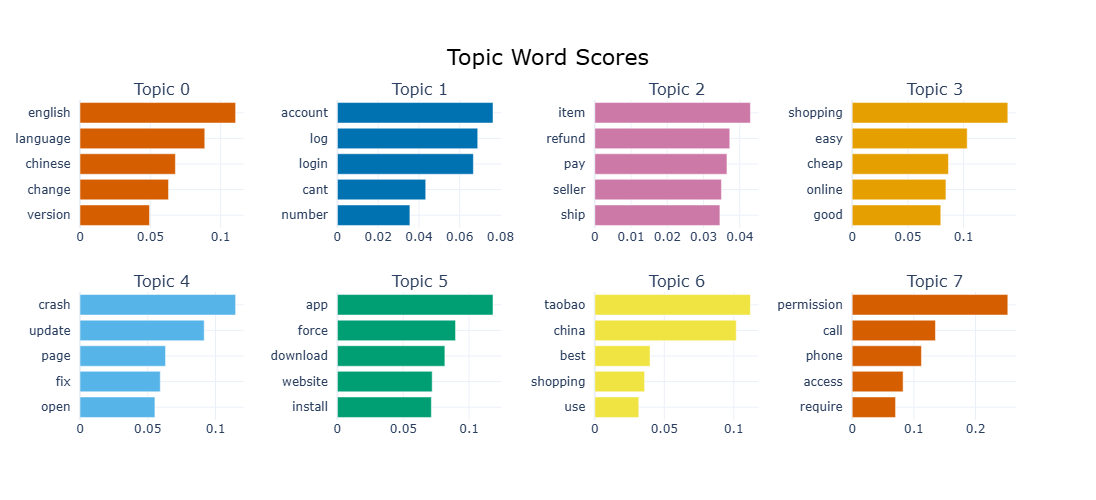

In [17]:
model.visualize_barchart()

#https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html
#Some topic in BERTopic has empty keywords
#This is generally not an error. It might happen that the collection of documents in that topic has very few or perhaps no words. 
#Other than that, it might even be that when you use the , certain documents will end up empty if it only consists of stop words.

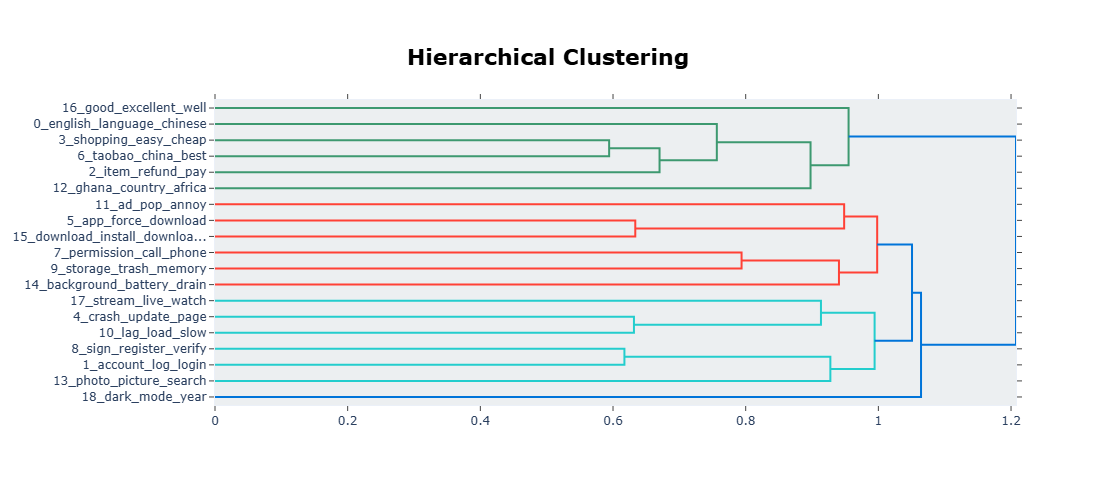

In [18]:
model.visualize_hierarchy()

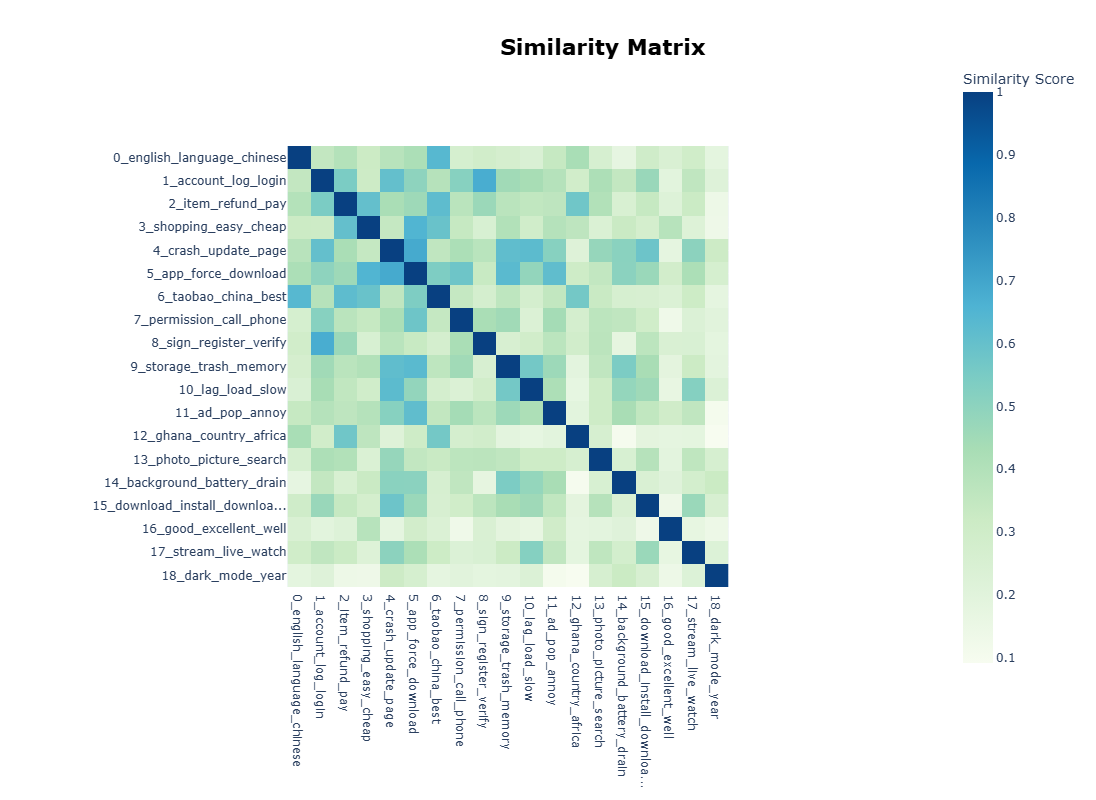

In [19]:
model.visualize_heatmap()

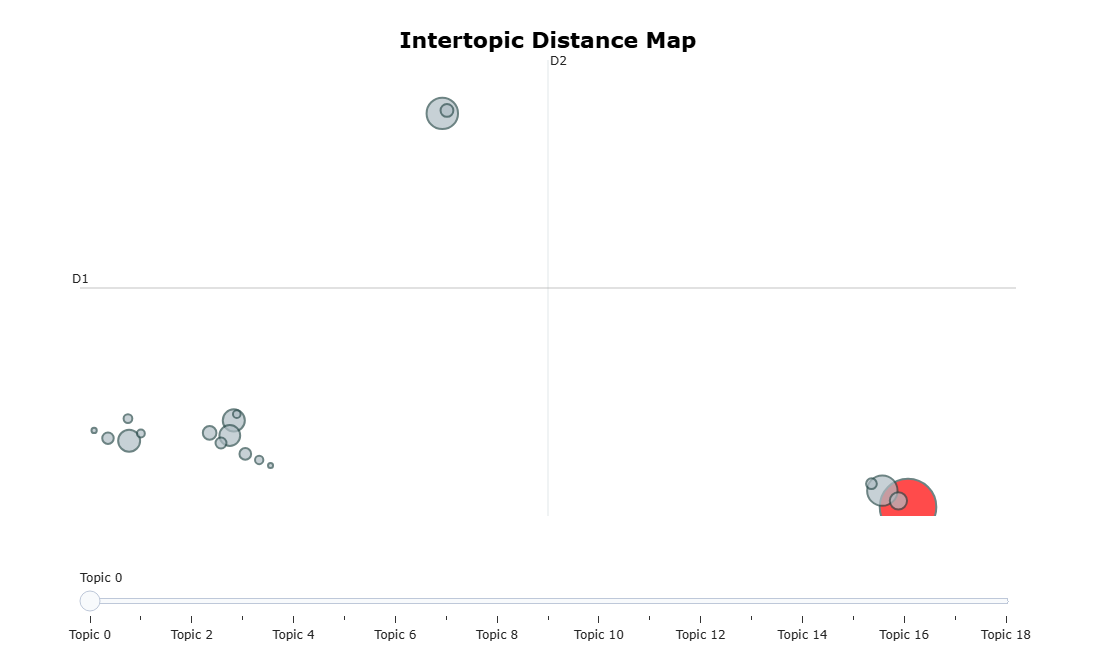

In [20]:
model.visualize_topics()

In [22]:
# 保存 BERTopic 可视化为 HTML 文件（解决 UnicodeEncodeError）
html_content = model.visualize_topics().to_html()

with open("bertopic_visualization.html", "w", encoding="utf-8") as file:
    file.write(html_content)

print("BERTopic_vis_HTML 文件已保存 ✅")


BERTopic_vis_HTML 文件已保存 ✅
